In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

xr.set_options(keep_attrs=True)


## Init dataset
dimension:
- time (01/01/2000 until from 01/12/2020)
- month (1 to 12)

In [44]:
time = pd.date_range(
        "01/2000",
        periods=20*12,
        freq=pd.DateOffset(months=1),
    )

amoc_dataset = xr.Dataset(
    data_vars=dict(),
    coords=dict(
        time=(["time"],time),
        month = (["month"], np.arange(1,13,1))
    ),
    attrs=dict(
        description="Aptherm Group Project to calculate the AMOC strength"
        ),
)


## Load datasets from all groups and adjust dimension names

In [52]:
DATAFOLDER = "data"

def RenameDimensionsAndVariables(dataset, dims_dict = dict(), vars_dict = False) :
    try:
        # rename the dimensions
        dataset = dataset.rename_dims(dims_dict)
        # rename coords assosiatet with dimensions
        try :
            dataset = dataset.rename_vars(dims_dict)
        except Exception as E :
            print(E)
        # rename the variables if necessary
        if vars_dict :
            dataset = dataset.rename_vars(vars_dict)
        return dataset
    except Exception as E :
        print(E)
        return None

# ============
# HYDROLOGICAL 
# group 1 and 2
hydrographic_mean = xr.open_dataset(DATAFOLDER + "/group1_mean_transport.nc")
hydrographic_mean = RenameDimensionsAndVariables(
            dataset = hydrographic_mean,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_mean"
                ))

hydrographic_climatology = xr.open_dataset(DATAFOLDER + "/group1_climatology_transport.nc")
hydrographic_climatology = RenameDimensionsAndVariables(
            dataset = hydrographic_climatology,
            dims_dict = dict(
                LONGITUDE = "longitude",
                PRESSURE = "pressure",
                TIME = "month"
                ),
            vars_dict = dict(
                __xarray_dataarray_variable__ = "hydrographic_climatology"
                ))

hydrographic_variability = xr.open_dataset(DATAFOLDER + "/group2_variability_interior_transport.nc")
hydrographic_variability = RenameDimensionsAndVariables(
            dataset = hydrographic_variability,
            dims_dict= 
            dict(
                lon = "longitude",
                p = "pressure",
            )
            )

# ============
# western boundary current
# group 3
western_boundary = xr.open_dataset(DATAFOLDER + "/group3_western_boundary_transport.nc")
western_boundary_monthly = western_boundary.resample(time="1MS").mean(dim="time")
western_boundary_monthly_std = western_boundary.resample(time="1MS").std(dim="time")

# ============
# ekman transport
# group 5
ekman_transport = xr.open_dataset(DATAFOLDER + "/group5_ekmann_transport.nc")

In [59]:
''' insert ekman_transport in Sv and westernboundary current to amoc dataset '''
western_boundary_attrs = dict(
    latitude = "11 deg S",
    longitude = "36 deg W - 34.8 deg W",
    depth = "0 - 2000 m",
    unit = "Sv",
    unit_full = "Sverdup are 1e6 m^3/s",
)
amoc_dataset['western_boundary_pos'] = western_boundary_monthly.Transport_pos
print(type(amoc_dataset))
amoc_dataset.western_boundary_pos.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport of the Brazil current in the upper layer towards the north",
                label = "Western boundary pos."
                )}
print(type(amoc_dataset))
amoc_dataset['western_boundary_neg'] = western_boundary_monthly.Transport_neg
amoc_dataset.western_boundary_neg.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport of the Brazil under current in the lower layer towards the south",
                label = "Western boundary transport south"
                )}

amoc_dataset['western_boundary'] = amoc_dataset.western_boundary_pos + amoc_dataset.western_boundary_neg
amoc_dataset.western_boundary.attrs = {
        **western_boundary_attrs,
        **dict(description = "Western boundary transport of the Brazil under current in the lower layer towards the south",
                label = "Western boundary transport total"
                )}

amoc_dataset['western_boundary_std'] = (western_boundary.Transport_pos + western_boundary.Transport_neg).resample(time= "1MS").std("time")

amoc_dataset

<class 'xarray.core.dataset.Dataset'>
<class 'xarray.core.dataset.Dataset'>


<xarray.Dataset>
Dimensions:               (month: 12, time: 240)
Coordinates:
  * time                  (time) datetime64[ns] 2000-01-01 ... 2019-12-01
  * month                 (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    western_boundary_pos  (time) float64 nan nan nan nan ... 22.49 22.12 nan nan
    western_boundary_neg  (time) float64 nan nan nan nan ... -11.54 nan nan
    western_boundary      (time) float64 nan nan nan nan ... 15.33 10.58 nan nan
    western_boundary_std  (time) float64 nan nan nan nan ... 5.599 8.461 nan nan
Attributes:
    description:  Aptherm Group Project to calculate the AMOC strength

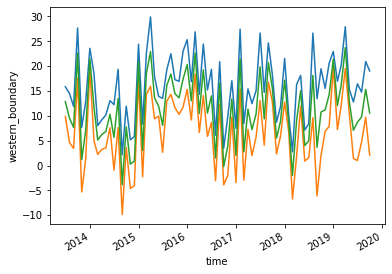

In [61]:
(amoc_dataset.western_boundary + amoc_dataset.western_boundary_std).plot()
(amoc_dataset.western_boundary - amoc_dataset.western_boundary_std).plot()
(amoc_dataset.western_boundary).plot()

## Calculate the monthly mean values and insert them into the amoc_dataset

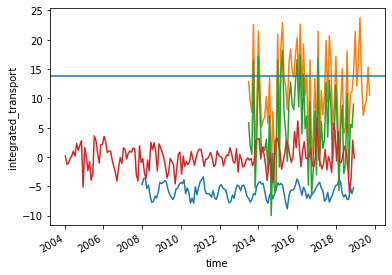

In [215]:
full_transport = False
for data_var in amoc_dataset :
    if full_transport is not False:
        full_transport = full_transport + amoc_dataset[data_var]
    else :
        full_transport = amoc_dataset[data_var]
    amoc_dataset[data_var].plot()
full_transport.plot()
hydrographic_variability.integrated_transport.plot()
plt.axhline(hydrographic_mean.hydrographic_mean.sum().values)

In [214]:
hydrographic_mean.hydrographic_mean.sum().values

array(13.80398812)